In [1]:
import numpy as np
import pcs as pcs
import matplotlib.pyplot as plt
from nepc import nepc
from nepc.methods.mp import mp as mp
from nepc.methods.thomson import thomson as thomson
from nepc.util.constants import N2_DIATOMIC_CONSTANTS
from nepc.util.constants import MU_NITROGEN_KG

# Computing the FCFs

In [2]:
N2_DIATOMIC_CONSTANTS.keys()

dict_keys(['N2(X1Sigmag+)', 'N2(A3Sigmau+)', 'N2(B3Pig)', 'N2(W3Deltau)', 'N2(Bp3Sigmau-)', 'N2(ap1Sigmau-)', 'N2(a1Pig)', 'N2(w1Deltau)', 'N2(C3Piu)', 'N2+(X2Sigmag+)', 'N2+(A2Piu)', 'N2+(B2Sigmau+)', 'N2+(C2Sigmau+)'])

In [2]:
p_list=['N2(X1Sigmag+)']
pp_list=['N2+(X2Sigmag+)', 'N2+(A2Piu)', 'N2+(B2Sigmau+)']
vp_list = np.arange(1)
vpp_list = np.arange(11)
jp_list = np.arange(1)
jpp_list = np.arange(1)
psi_p_keep = [p_list,[0,5,10],[0]]
psi_pp_keep = [pp_list,[0,5,10],[0]]
dbug = False
Vr_p, Vr_pp, psi_p, psi_pp, fcf = thomson.fcf(p_list, pp_list, vp_list, vpp_list, jp_list, jpp_list,
                                              diatomic_constants=N2_DIATOMIC_CONSTANTS,
                                              reduced_mass=MU_NITROGEN_KG,
                                              k=17,
                                              delta_r=.5,
                                              psi_p_keep=psi_p_keep,
                                              psi_pp_keep=psi_pp_keep,
                                              dbug=False)

In [3]:
fcf

[[[[[[0.9111053554293523,
      0.08578454898490828,
      0.0030890683690264894,
      1.2188887890569222e-05,
      6.407390005207784e-06,
      2.1572293043248827e-06,
      2.576434906620324e-07,
      1.569375162339991e-08,
      3.234213089814609e-10,
      1.9700860311339444e-10,
      2.7936018037018185e-11]]]],
  [[[[0.2510403690196151,
      0.32947802319931685,
      0.23299253538095982,
      0.11744680528924896,
      0.04707701320720317,
      0.015851710210823256,
      0.004615733466871714,
      0.0011769619827573026,
      0.0002622523227593461,
      5.0046434692287646e-05,
      7.6193968844718935e-06]]]],
  [[[[0.8752507226304342,
      0.12087468128009445,
      0.003869932676010388,
      1.7877596159402138e-06,
      2.8658021928482722e-06,
      2.967379017517014e-09,
      6.444278137556794e-09,
      4.3139245690059095e-10,
      6.960548189062843e-12,
      8.078479799870244e-14,
      1.3615388849141739e-12]]]]]]

# Closure relationship for FCF
If the FCF sum over vpp for a given vp are greater than 0.99, that's were we'll stop including cross sections

In [4]:
max_vpp = []
for pp in np.arange(3):
    sum_fcf = 0
    vpp = -1
    while sum_fcf < 0.99:
        vpp += 1
        sum_fcf += fcf[0][pp][0][0][0][vpp]
    print('pp: {}; vpp: {}; sum_fcf = {} > 0.99'.format(pp, vpp, sum_fcf))
    max_vpp.append(vpp)

pp: 0; vpp: 1; sum_fcf = 0.9968899044142606 > 0.99
pp: 1; vpp: 5; sum_fcf = 0.9938864563071671 > 0.99
pp: 2; vpp: 1; sum_fcf = 0.9961254039105287 > 0.99


In [5]:
max_vpp

[1, 5, 1]

# Total cross section data from literature

In [6]:
INCIDENT_ENERGY = [16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 24.5, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0, 110.0, 120.0, 140.0, 160.0, 180.0, 200.0, 225.0, 250.0, 275.0, 300.0, 350.0, 400.0, 450.0, 500.0, 550.0, 600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1000.0]
ITIKAWA = np.asarray([0.0211, 0.0466, 0.0713, 0.0985, 0.129, 0.164, 0.199, 0.23, 0.27, 0.308, 0.344, 0.38, 0.418, 0.455, 0.492, 0.528, 0.565, 0.603, 0.64, 0.929, 1.16, 1.37, 1.52, 1.6, 1.66, 1.72, 1.74, 1.78, 1.8, 1.81, 1.82, 1.83, 1.85, 1.85, 1.83, 1.81, 1.78, 1.72, 1.67, 1.61, 1.55, 1.48, 1.41, 1.37, 1.28, 1.2, 1.11, 1.05, 0.998, 0.943, 0.88, 0.844, 0.796, 0.765, 0.738, 0.719, 0.698, 0.676])

# Function to compute partial cross section data array

In [29]:
def compute_pcs_array(a, b, c):
    ee_pcs = []
    for pp in np.arange(3):
        for vpp in np.arange(max_vpp[pp]+1):
            pcs_data = pcs.pcs(p_state=p_list[0], pp_state=pp_list[pp], 
                               vp=0, vpp=vpp, fcf=fcf[0][pp][0][0][0][vpp],
                               a=a[pp+vpp], b=b, c=c)
            sigmas = []
            for i in range(len(pcs_data)):
                sigmas.append(pcs_data[i][1])
            ee_pcs.append(sigmas)
    return ee_pcs

# Initial guess for universal function parameters

In [67]:
a=np.zeros(10)+2.6
b=2.4
c=9.2

In [68]:
ee_pcs = np.asarray(compute_pcs_array(a, b, c))
len(ee_pcs)

10

In [69]:
len(ee_pcs[0])

58

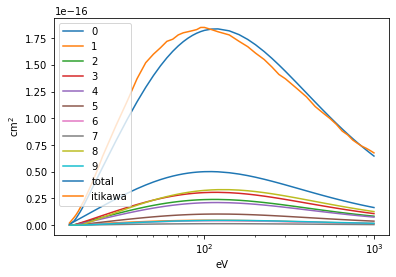

In [70]:
fig1, ax1 = plt.subplots(1)
for i in range(len(ee_pcs)):
    ax1.plot(INCIDENT_ENERGY, ee_pcs[i]*100**2, label='{}'.format(i))
ax1.plot(INCIDENT_ENERGY, np.sum(ee_pcs*100**2, axis=0), label='total')
ax1.plot(INCIDENT_ENERGY, ITIKAWA*1.0E-16, label='itikawa')
ax1.set_xscale('log')
ax1.set_ylabel('cm$^2$')
ax1.set_xlabel('eV')
ax1.legend()
plt.show()

In [5]:
X1_X2 = []
for vp in vp_list:
    """X1_X2[vp]"""
    X1_X2.append([])
    for vpp in vpp_list:
        """X1_X2[vp][vpp][pcs]"""
        sigma = []
        for i in np.arange(58):
            sigma.append(ee_pcs[0][0][vp][vpp][i][1])
        X1_X2[vp].append(np.asarray(sigma))

X1_A2 = []
for vp in vp_list:
    """X1_A2[vp]"""
    X1_A2.append([])
    for vpp in vpp_list:
        """X1_A2[vp][vpp][pcs]"""
        sigma = []
        for i in np.arange(58):
            sigma.append(ee_pcs[0][1][vp][vpp][i][1])
        X1_A2[vp].append(np.asarray(sigma))
        
X1_B2 = []
for vp in vp_list:
    """X1_B2[vp]"""
    X1_B2.append([])
    for vpp in vpp_list:
        """X1_B2[vp][vpp][pcs]"""
        sigma = []
        for i in np.arange(58):
            sigma.append(ee_pcs[0][2][vp][vpp][i][1])
        X1_B2[vp].append(np.asarray(sigma))

# Figures and Tables

## N2 X1Sigmag+ to N2+ X2Sigmag+

In [22]:
"""Table data in LaTeX format"""
print('\hline')
for i in np.arange(58):
    print(r'   %.1f & %.4f & %.4f & %.4f \\' %(INCIDENT_ENERGY[i], X1_X2[0][0][i]*1e20, X1_X2[0][1][i]*1e20, (X1_X2[0][0][i]+X1_X2[0][1][i])*1e20))
print('\hline')

\hline
   16.0 & 0.1776 & 0.0057 & 0.1833 \\
   16.5 & 0.3846 & 0.0245 & 0.4090 \\
   17.0 & 0.5864 & 0.0428 & 0.6292 \\
   17.5 & 0.7833 & 0.0607 & 0.8440 \\
   18.0 & 0.9755 & 0.0781 & 1.0536 \\
   18.5 & 1.1629 & 0.0951 & 1.2580 \\
   19.0 & 1.3459 & 0.1117 & 1.4576 \\
   19.5 & 1.5244 & 0.1280 & 1.6524 \\
   20.0 & 1.6987 & 0.1438 & 1.8425 \\
   20.5 & 1.8689 & 0.1593 & 2.0281 \\
   21.0 & 2.0350 & 0.1744 & 2.2093 \\
   21.5 & 2.1972 & 0.1891 & 2.3863 \\
   22.0 & 2.3556 & 0.2036 & 2.5591 \\
   22.5 & 2.5102 & 0.2176 & 2.7279 \\
   23.0 & 2.6613 & 0.2314 & 2.8927 \\
   23.5 & 2.8089 & 0.2448 & 3.0537 \\
   24.0 & 2.9531 & 0.2580 & 3.2111 \\
   24.5 & 3.0939 & 0.2708 & 3.3648 \\
   25.0 & 3.2316 & 0.2834 & 3.5149 \\
   30.0 & 4.4478 & 0.3945 & 4.8423 \\
   35.0 & 5.4201 & 0.4836 & 5.9037 \\
   40.0 & 6.2014 & 0.5554 & 6.7568 \\
   45.0 & 6.8315 & 0.6135 & 7.4451 \\
   50.0 & 7.3405 & 0.6606 & 8.0011 \\
   55.0 & 7.7514 & 0.6988 & 8.4502 \\
   60.0 & 8.0824 & 0.7297 & 8.8121 \\
   65

## N2 X1Sigmag+ to N2+ A2Piu

In [ ]:
fig2, ax2 = plt.subplots(1)
ax2.plot(INCIDENT_ENERGY, X1_A2[0][0]*100**2, 'r-', label='vpp=0')
ax2.plot(INCIDENT_ENERGY, X1_A2[0][1]*100**2, 'b-', label='vpp=1')
ax2.plot(INCIDENT_ENERGY, X1_A2[0][2]*100**2, 'g-', label='vpp=2')
ax2.plot(INCIDENT_ENERGY, X1_A2[0][3]*100**2, 'k-', label='vpp=3')
ax2.plot(INCIDENT_ENERGY, X1_A2[0][4]*100**2, 'm-', label='vpp=4')
ax2.plot(INCIDENT_ENERGY, X1_A2[0][5]*100**2, 'c-', label='vpp=5')
ax2.plot(INCIDENT_ENERGY, (X1_A2[0][0]+X1_A2[0][1]+X1_A2[0][2]+X1_A2[0][3]+X1_A2[0][4]+X1_A2[0][5])*100**2, 'y-', label='sum')
ax2.set_xscale('log')
ax2.set_ylabel('cm$^2$')
ax2.set_xlabel('eV')
ax2.set_title(r'N$_2$ X$^1\Sigma_g^+$ to N$_2^+$ A$^2\Pi_u$')
ax2.legend()
plt.show()

## N2 X1Sigmag+ to N2+ B2Sigmau+

In [ ]:
fig3, ax3 = plt.subplots(1)
ax3.plot(INCIDENT_ENERGY, X1_B2[0][0]*100**2, 'r-', label='vpp=0')
ax3.plot(INCIDENT_ENERGY, X1_B2[0][1]*100**2, 'b-', label='vpp=1')
ax3.plot(INCIDENT_ENERGY, (X1_B2[0][0]+X1_B2[0][1])*100**2, 'y-', label='sum')
ax3.set_xscale('log')
ax3.set_ylabel('cm$^2$')
ax3.set_xlabel('eV')
ax3.set_title(r'N$_2$ X$^1\Sigma_g^+$ to N$_2^+$ B$^2\Sigma_u^+$')
ax3.legend()
plt.show()

## Comparison against Itikawa compiled cross sections
The Itikawa total cross sections need to be multiplied by 18 to reach our total

In [ ]:
N2_N2P_TCS = X1_X2[0][0]+X1_X2[0][1]+X1_A2[0][0]+X1_A2[0][1]+X1_A2[0][2]+X1_A2[0][3]+X1_A2[0][4]+X1_A2[0][5]+X1_B2[0][0]+X1_B2[0][1]

fig4, ax4 = plt.subplots(1)
ax4.plot(INCIDENT_ENERGY, ITIKAWA*10**(-16), 'r-', label='Itikawa')
ax4.plot(INCIDENT_ENERGY, N2_N2P_TCS*100**2, 'k-', label='Total')
ax4.set_xscale('log')
ax4.set_ylabel('cm$^2$')
ax4.set_xlabel('eV')
ax4.set_title(r'Comparision of Itikawa to our Total')
ax4.legend()
plt.show()